## Erstellung von Höhenlinien mit OpenData und Open-Source-Werkzeugen

Im Folgenden soll beispelhaft gezeigt werden, wie man aus einem Digitalen Geländemodell (DGM) bzw. digial elevation model (DEM) Höhenlinien ableiten kann.

Zum Einsatz kommen Python 3.10 und diverse Open-Source-Bibliotheken.

* [Rasterio](https://rasterio.readthedocs.io/en/latest/) zur Verarbeitung von Raster-Geodaten
* [NumPy](https://numpy.org/) zur Manipulation (Umrechung) von Daten
* [SciPy](https://scipy.org/) zum Filtern und Glätten der Daten
* [xarray-spatial](https://github.com/makepath/xarray-spatial) zur Analyse der Daten
* [RichDEM](https://richdem.readthedocs.io/en/latest/) zur Berechnung der Hangneigung
* [Shapely](https://shapely.readthedocs.io/en/stable/manual.html) zur Manipulation von Vektordaten (klassifiziertes Gefälle und Höhenlinien)
* [Fiona](https://fiona.readthedocs.io/en/latest/) zum Speichern der Höhenlinien als Shape-File

Dazu wurden zur Darstellung des Verfahrens
* [jupyter](https://jupyter.org/),
* [matplotlib-pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html) und
* [GeoPandas](https://geopandas.org/en/stable/)

verwendet.

Diverse weitere beispielhafte Darstellungen wurden mit [QGIS](https://www.qgis.org/de/site/) erstellt.

In [1]:
import numpy as np
import rasterio
import xarray as xr
from scipy.ndimage import gaussian_filter
from xrspatial import focal

### Geländemodell laden
Die Datei [`725_5287.tif`](https://download1.bayernwolke.de/a/dgm/dgm1/725_5287.tif) aus dem OpenData-Angebot der bayerischen Vermessungsverwaltung enthält ein digitales Geländemodell mit 1m Bodenauflösung
für ein 1km² großes Gebiet südwestlich des Wendelsteingipfels.

Zunächst wird diese Datei mittels `rasterio` geladen.

In [2]:
with rasterio.open("725_5287.tif") as dem_file:
    dem = dem_file.read(1)
    transform = dem_file.transform
    crs = dem_file.crs.wkt
    bounds = dem_file.bounds

Mit `pyplot` aus dem `matplotlib`-Paket lassen sich die Daten graphisch darstellen:

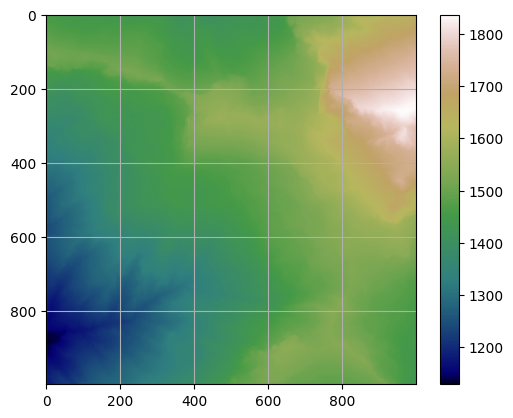

In [3]:
import matplotlib.pyplot as plt
im = plt.imshow(dem, cmap='gist_earth')
plt.grid()
plt.colorbar(im)
plt.show()

### Geländemodell glätten
Das Geländemodell ist sehr hoch aufgelöst. Wenn man sich mittels `gdal_contour` die Höhenlinien unmittelbar aus dem DGM ableiten lässt werden sie
sehr unruhig.

Zum selbst ausprobieren:

    gdal_contour -i 5 725_5287.tif 725_5287.shp

Wenn man sich die daraus entstandene Shape-Datei - beispielsweise mit QGIS - anschaut, dann sieht man was gemeint ist ...

![gdal_contours](images/small_725_5287.png)

Es ist also notwendig, das DGM vorher zu glätten. Hierzu verwenden wir einen Algorithmus, der in folgender Publikation beschrieben ist:

> P. Kettunen, C. Koski, and J. Oksanen, “A design of contour generation for topographic maps with adaptive DEM smoothing,”
> International Journal of Cartography, vol. 3, no. 1, pp. 19–30, Jun. 2017.
> DOI: [10.1080/23729333.2017.1300998](https://doi.org/10.1080/23729333.2017.1300998)

Die Parameter für das Gauss-Filter sind durch Ausprobieren ermittelt worden und stellen sicher nicht der Weisheit letzten Schluss dar ...

Als Resultat erhalten wir ein geglättetes DGM.

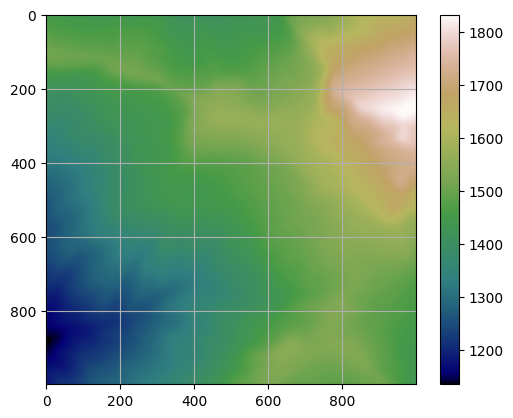

In [4]:
smoothend_dem = gaussian_filter(dem, sigma=10, radius=10)
hard_smoothend_dem = gaussian_filter(dem, sigma=10, radius=20)

tpi = dem - focal.mean(xr.DataArray(dem)).to_numpy()
tpi_pos = np.where(tpi >= 0, tpi, -1 * tpi)
tpi_norm = tpi_pos / np.max(tpi_pos)
cdem = tpi_norm * smoothend_dem + (1 - tpi_norm) * hard_smoothend_dem

im = plt.imshow(cdem, cmap='gist_earth')
plt.grid()
plt.colorbar(im)
plt.show()

### Hangneigung

Nun rechnen wir uns aus dem geglätteten DGM noch die Hangneigung (slope), die wir später brauchen.

Die Warnungen von `richdem` interessieren uns an dieser Stelle nicht.

In [5]:
import richdem as rd
rdem = rd.rdarray(cdem, no_data=-9999)
slope = rd.TerrainAttribute(rdem, attrib='slope_degrees')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0269869====================== ] (99% - 0.0s - 1 threads)


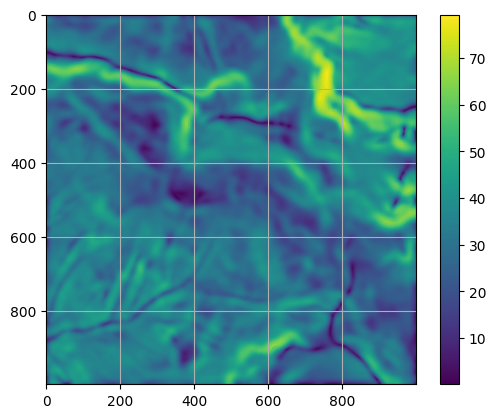

In [6]:
im = plt.imshow(slope)
plt.grid()
plt.colorbar(im)
plt.show()

Die ermittelte Hangneigung wird nun in 10°-Schritte klassifiziert und in Polygone "verpackt".

In [7]:
from shapely.geometry import shape, MultiPolygon
from rasterio import features
slope_classified = np.round(slope/10) * 10
min = int(np.min(slope_classified))
max = int(np.max(slope_classified))
rawclasses = {}
classes = {}
for i in range(min, max+10, 10):
    rawclasses[i] = []
    classes[i] = None
shapes = features.shapes(slope_classified, transform=transform)

for s in list(shapes):
    sg, val = s
    g = shape(sg)
    rawclasses[int(val)].append(g)
for v in rawclasses.keys():
    for g in rawclasses[v]:
        if classes[v] is None:
            classes[v] = g
        else:
            classes[v] = classes[v].union(g)
for v in classes.keys():
    if v > 0:
        for w in [x for x in classes.keys() if x > v]:
            classes[v] = classes[v].union(classes[w])
            classes[v] = classes[v]
            if classes[v].geom_type == 'Polygon':
                classes[v] = MultiPolygon([classes[v]])

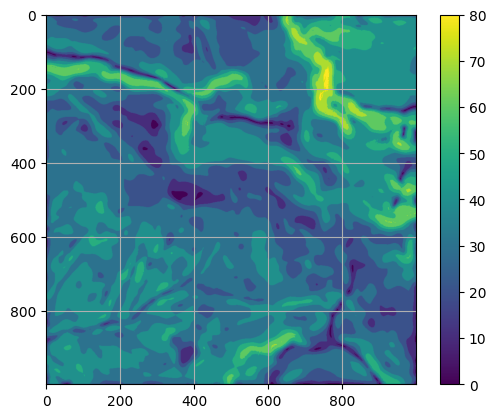

In [8]:
im = plt.imshow(slope_classified)
plt.grid()
plt.colorbar(im)
plt.show()

### Höhenlinien berechnen

Nun lassen wir uns die Höhenlinien berechnen. Das macht `contourpy` für uns.

Die berechneten Linien speichern wir - in `shapely`-Linestrings umgewandelt, in einem Dictionary mit der Höhe als Key.

Wir haben jetzt Höhenlinien. :-)

Aber: wir sind im alpinen Bereich unterwegs, die Hänge sind steil. Aus Höhenlinien mit 5m Abstand wird bei entsprechend kleinem Maßstab ein vollflächiger Farbklecks.

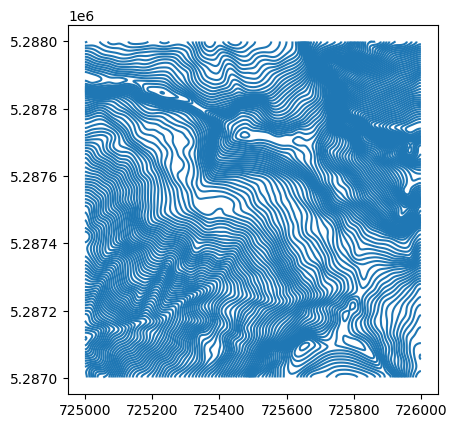

In [9]:
from shapely import LineString
from shapely.geometry import mapping
from collections import OrderedDict
from contourpy import contour_generator
from shapely.affinity import affine_transform
from contourpy.util.mpl_renderer import MplRenderer as Renderer

start = round(np.min(dem) / 10) * 10 - 10
stop = round(np.max(dem) / 10) * 10 + 10
levels = np.arange(start, stop, 5.0).tolist()
cont_gen = contour_generator(z=cdem, quad_as_tri=False)

contour_lines = {}
for i, level in enumerate(levels):
    generated_lines = cont_gen.lines(level)
    contour_lines[int(level)] = []
    for g_line in generated_lines:
        contour_lines[int(level)].append(affine_transform(LineString(g_line), transform.to_shapely()))
import geopandas as gpd
contours = []
for lvl, lns in contour_lines.items():
    if len(lns) > 0:
        for l in lns:
            contours.append(l)
p = gpd.GeoSeries(contours)
p.plot()
plt.show()

### Höhenlinien reduzieren

Wir haben die Höhenlinien als Linestrings und die klassifizierten Hangneigungen als Polygone.
Leider kann `shapely` Linestrings nicht unmittelbar an Polygonen abschneiden. Wir gehen also über einen Zwischenschnitt und zerschneiden die Linie zunächst an den Polygongrenzen. Anschliessend prüfen wir, welche Linien wegfallen und welche wir behalten wollen.

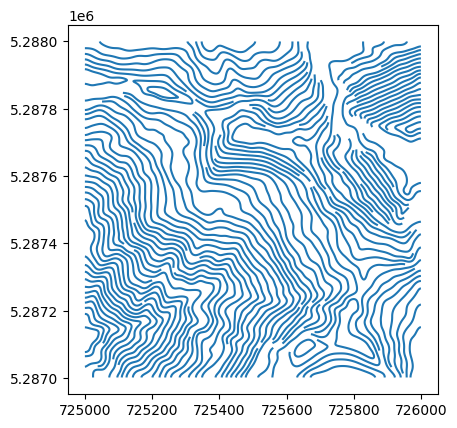

In [10]:
from shapely.ops import split
from shapely import MultiLineString
steps = [5, 10, 20, 100]
cuts = {5: 10, 10: 50, 20: 60}
cutted_lines = {}
for i in range(len(steps)-1):
    s = steps[i]
    n = steps[i+1]
    for val in [h for h in contour_lines.keys() if h % s == 0 and h % n != 0]:
        cutted_lines[val] = []
        p = classes[cuts[s]]
        l = MultiLineString(contour_lines[val])
        parts = split(l, p)
        if parts.geom_type == 'GeometryCollection':
            for g in parts.geoms:
                if g.geom_type == 'LineString':
                    if g.length > 100:
                        if not g.covered_by(p):
                            cutted_lines[val].append(g)
    for val in [h for h in contour_lines.keys() if h % steps[-1] == 0]:
        cutted_lines[val] = []
        for l in contour_lines[val]:
            cutted_lines[val].append(l)
contours = []
for lvl, lns in cutted_lines.items():
    if len(lns) > 0:
        for l in lns:
            contours.append(l)
p = gpd.GeoSeries(contours)
p.plot()
plt.show()

### Höhenlinien speichern

Zum Schluss werden die so berechneten Höhenlinien in ein Shapefile geschrieben. Nun können sie in einem GIS-Programm angeschaut und gestyled werden.

In [11]:
import fiona

contours_schema = {
    'geometry': 'LineString',
    'properties': OrderedDict([
        ('elev', 'float')
    ])
}

with fiona.open(
        'contours.shp',
        'w',
        driver='ESRI Shapefile',
        crs=crs,
        schema=contours_schema) as target:
        for level, lns in cutted_lines.items():
            for l in lns:
                ls = mapping(l)
                target.write({'geometry': ls, 'properties': OrderedDict([('elev', level)])})

Hier ein Beispiel für Höhenlinien nach Bearbeitung mit QGIS:
![berechnete Höhenlinien](images/small_c2.png)
